In [2]:
import torch 
import torch.nn as nn


The transformer block is composed of different components as shown:

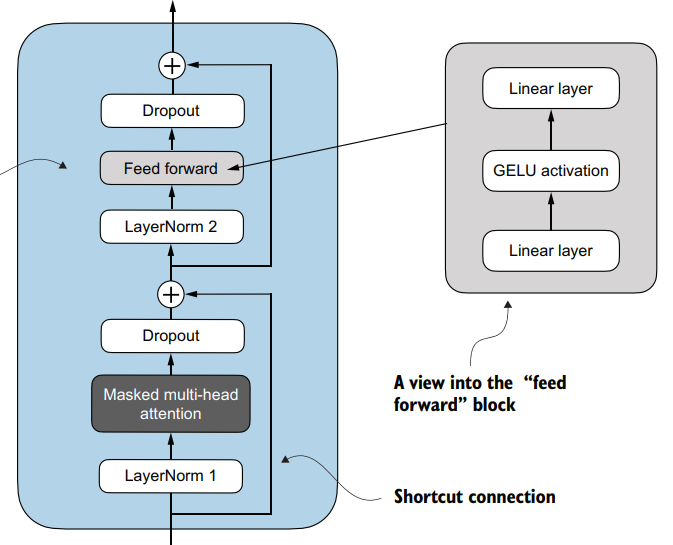

To implement these, we will proceed step by step as follows:

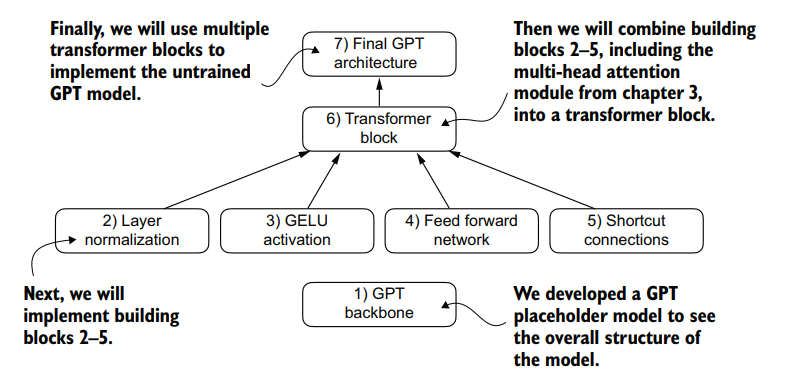

### But Why is Layer normalization needed?
In deep neural networks like transformers, the stability and efficiency of training depend heavily on managing the flow of gradients during backpropagation. Layer normalization plays a critical role in achieving this stability. Here's why:

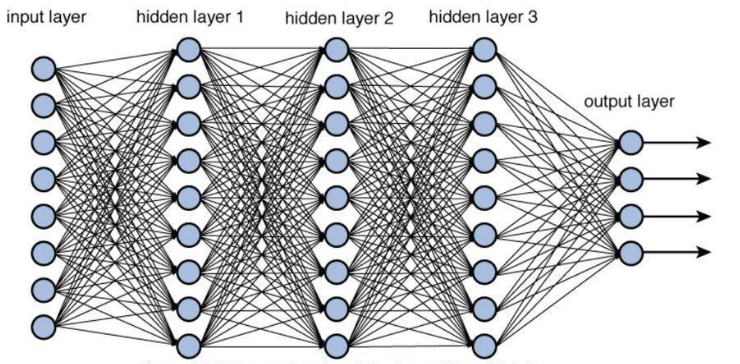

1. **Controlling Gradient Magnitudes**

    The gradients used in backpropagation depend on the layer outputs. Without proper control, these outputs can lead to two problematic scenarios:

    a. **Exploding Gradients**: If the output magnitudes of later layers are large, the gradients can grow exponentially as they propagate backward through the network. This causes parameter updates to become unstable, leading to divergent or erratic model behavior.

    b. **Vanishing Gradients**: Conversely, if the output magnitudes are too small, the gradients may shrink to near-zero values as they propagate backward. This slows down or halts the learning process, particularly for earlier layers, resulting in poor convergence.

    Layer normalization addresses this by normalizing the outputs of each layer to have a mean of zero and a standard deviation of one (before scaling and shifting). This ensures that the layer outputs remain within a stable range, preventing extreme gradient magnitudes and enabling consistent training.


2. **Mitigating Internal Covariate Shift**

    Internal covariate shift refers to the change in the distribution of layer outputs during training as the parameters of preceding layers are updated. This shift forces later layers to continuously adapt to new input distributions, slowing down convergence and complicating optimization.

    Layer normalization reduces internal covariate shift by standardizing the inputs to each layer (or sub-layer, such as attention or feed-forward networks in transformers) across the feature dimension for each training example. This ensures that the distribution of layer inputs remains consistent, regardless of changes in earlier layers, leading to faster and more stable training.

3. **Enabling Robust Training in Transformers**

    Transformers process sequences using attention mechanisms and feed-forward networks, which can amplify variations in input magnitudes across layers. Layer normalization, applied after sub-layers (e.g., multi-head attention and feed-forward networks), ensures that these variations do not destabilize the model. It also allows transformers to handle diverse sequence lengths and input distributions effectively, making training more robust.

#### The main idea behind layer normalization is to adjust the activations (outputs) of a neural network layer to have a mean of 0 and a variance of 1, also known as unit variance.
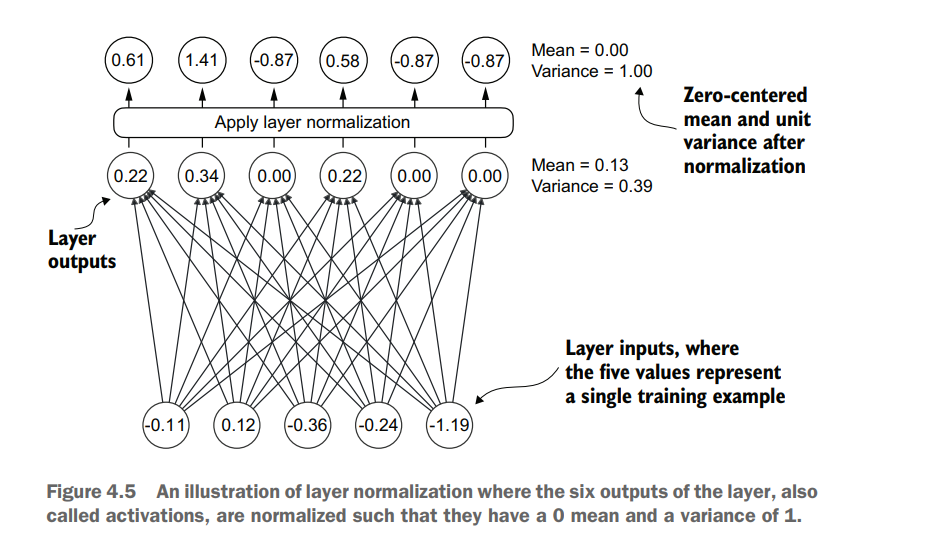

In [3]:
torch.manual_seed(123)

batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)

print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [4]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


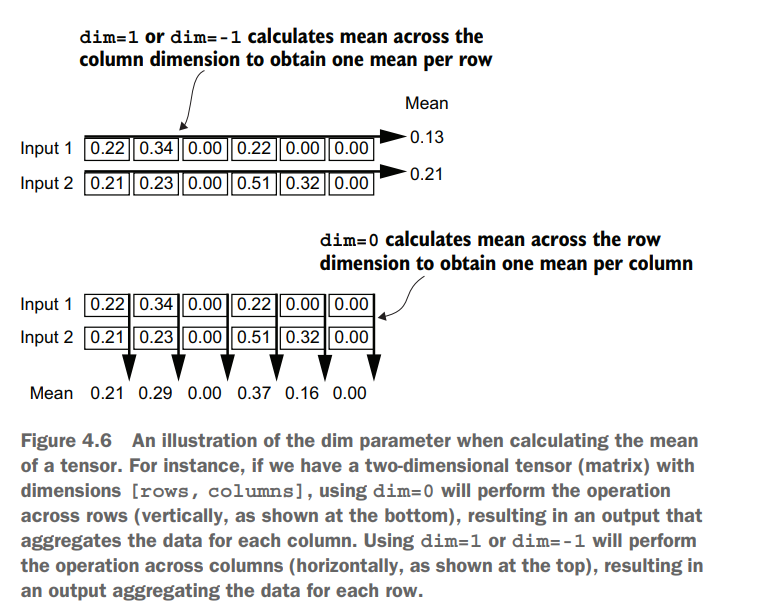

Using `keepdim=True` in operations like mean or variance calculation ensures that the
output tensor retains the same number of dimensions as the input tensor, even though
the operation reduces the tensor along the dimension specified via `dim`. 

In [5]:
mean = out.mean(dim=-1)
var = out.var(dim=-1)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([0.1324, 0.2170], grad_fn=<MeanBackward1>)
Variance:
 tensor([0.0231, 0.0398], grad_fn=<VarBackward0>)


#### Now, let's apply Layer normalization

In [7]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [8]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


### Class Implementation of LayerNorm

Wherever we implement the `layerNorm` in the transformer architecture the last dimension of input to the `layerNorm` is always the embedding dimension (Refer to the `GPT_dummy` if confused).

In [10]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5 # epsilon to avoid division by zero
        
        # Two trainable parameters scale and shift are initialized to 1 and 0 respectively
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        var = x.var(dim = -1, keepdim = True, unbiased = False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        
        return self.scale * norm_x + self.shift
    

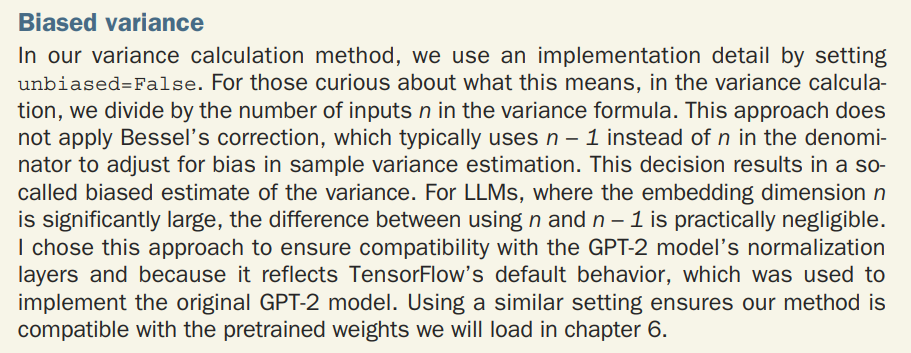